# Analyzing New Solar Events with the Model

This notebook allows to analyze specific solar events. Users can input a **date**, **location** on the Sun and **duration**. The notebook then generates a complete animation showcasing the solar region, and a prediction and localisation whether a solar jet is present in the observed area.







In [14]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import warnings
import math

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision

#Model
from torch.nn.init import xavier_uniform_, constant_, uniform_, normal_
from torch import nn, Tensor
import torch.nn.functional as F
from torchvision.transforms import functional
import copy
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from TransVOD.TransVOD_Lite.util.misc_multi import nested_tensor_from_tensor_list
import MultiScaleDeformableAttention as MSDA


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
import os
import sys
import matplotlib
import PIL
from PIL import Image
from typing import Optional

import TransVOD.TransVOD_Lite.util.misc_multi as utils
from TransVOD.TransVOD_Lite.models import build_model

ModuleNotFoundError: No module named 'util'

<div style="width: 1350px; height: 30px; background-color: green;"></div>


# 0. Inputs of Event

In [ ]:
basepoint_x = -226.577125
basepoint_y = -956.964375
start_time = '2016-07-09T06:55:58'

jsoc_email = 'adrien.joliat@epfl.ch'

threshold=0.25       # How certain we want to be to predict a jet event

# cadence (24s per image)

<div style="width: 1350px; height: 30px; background-color: green;"></div>


# 1. Create Input to the Model

## Image Classification Model Requirements

### Image Sequence Requirements:
- **Time Interval:** Each image should be captured at intervals of 24 seconds. While the model can handle varying intervals, it has been trained for the 24-second interval at 304 Angstrom. Deviations might result in reduced accuracy.

### Image Size and Format:
- **Processed Image :** Before feeding them to the model, these images are transformed from numpy arrays into JPEG images.

In [19]:
def get_images(time_start, basepoint_x, basepoint_y, jsoc_email):
    with contextlib.redirect_stdout(io.StringIO()): # Suppressing print statements
        start_time = Time(time_start, scale='utc', format='isot')
        bottom_left = SkyCoord((basepoint_x-150)*u.arcsec, (basepoint_y-150)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")
        top_right = SkyCoord((basepoint_x+150)*u.arcsec, (basepoint_y+150)*u.arcsec, obstime=start_time, observer="earth", frame="helioprojective")

        cutout = a.jsoc.Cutout(bottom_left=bottom_left, top_right=top_right, tracking=True)

        query = Fido.search(
            a.Time(start_time , start_time + (30-1)*24*u.s), # we stop for n images
            a.Wavelength(304*u.angstrom),
            a.Sample(24*u.s), 
            a.jsoc.Series.aia_lev1_euv_12s,
            a.jsoc.Notify(jsoc_email),
            a.jsoc.Segment.image,
            cutout,
        )
        files = Fido.fetch(query, overwrite=True)
    
    files.sort()
    return files

## Download Images (30 .fits files)

In [20]:
files = get_images(start_time, basepoint_x, basepoint_y, jsoc_email)

### Check that it contains 30 files.
A few times, some data is not available in JSOC and less images are downloaded, and the model cannot run less than 30 images

In [ ]:
if(len(files) == 30):
    print('Data has the correct shape')
else: 
    print('Data has the wrong shape. The model will not work')

Data has the correct shape


## Transform image to np array

In [ ]:
def array_file(files): 
    """
    Inputs:
    files:              sunpy content, Files extracted from the Jsoc database 

    Return:     
    sequence_array:     numpy array, Shape [height, width, num_images] (166,166,30)      
    """
    # Initialize the 3D matrix
    sequence_array = np.zeros((166, 166, len(files)))
    downsampling_layer = torch.nn.MaxPool2d(3, stride=3)
    # "files" is (class <parfive>) and contains N <HDUList> objects (where N is the nb of images in the sequence) 
    for i in range(len(files)):
        with fits.open(files[i]) as f:
            array = (f[1].data).astype(np.float32)
            array = torch.from_numpy(array).unsqueeze(0).unsqueeze(0)
            array = downsampling_layer(array)
            sequence_array[:,:,i] = array.numpy()

    return sequence_array

In [ ]:
# Convert to numpy array
array = array_file(files)
array2 = array      # just a copy of array in case we run this cell twice by mistake

# Save the numpy array as a compressed file
np.savez_compressed("./new data/"+"jet1.npz" , array)

# We don't want to store the files in the computer. Delete them (they take A LOT of storage otherwise)
for j in range(len(files)):
    os.remove(files[j])

## Re-import now as the correct Torch file for the CNN

In [ ]:
class TensorTransforms:
    def __init__(self, rotate_angle=30):
        self.rotate_angle = rotate_angle

    def random_horizontal_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [2])  # Flip along width
        return x

    def random_vertical_flip(self, x):
        if random.random() > 0.5:
            return torch.flip(x, [1])  # Flip along height
        return x

    def random_rotation(self, x):
        # Random rotation in increments of 90 degrees for simplicity
        k = random.randint(0, 3)  # 0, 90, 180, or 270 degrees
        return torch.rot90(x, k, [1, 2])  # Rotate along height and width

    def __call__(self, x):
        x = self.random_horizontal_flip(x)
        x = self.random_vertical_flip(x)
        x = self.random_rotation(x)
        return x

class NPZDataset(Dataset):
    def __init__(self, data_dir, augment=True, mean=None, std=None):
        self.data_dir = data_dir
        self.augment = augment
        self.files = [f for f in os.listdir(data_dir) if self._check_file_shape(f)]
        self.transform = TensorTransforms()
        self.mean = mean
        self.std = std

    def _check_file_shape(self, file):
        file_path = os.path.join(self.data_dir, file)
        data = np.load(file_path)['arr_0']
        return data.shape == (166, 166, 30)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)['arr_0']
        data = np.moveaxis(data, -1, 0)  # Move channel to first dimension

        data = torch.from_numpy(data).float()  # Convert to PyTorch tensor

        if self.augment:
            data = self.transform(data)

        if self.mean is not None and self.std is not None:
            data = np.clip(data, a_min=None, a_max= 1000)
            data = (data - self.mean) / self.std


        label = 1.0 if 'data1' in self.data_dir else 0.0

        return data, np.float32(label)

In [ ]:
# Load the data
data_dir = './new data/'
mean_data = 50.564544677734375
std_data = 49.94772720336914

data = NPZDataset(data_dir, mean=mean_data, std=std_data, augment=False)
data_array = data[0][0].numpy()

# 2. Visualize Image

May it contain a jet?

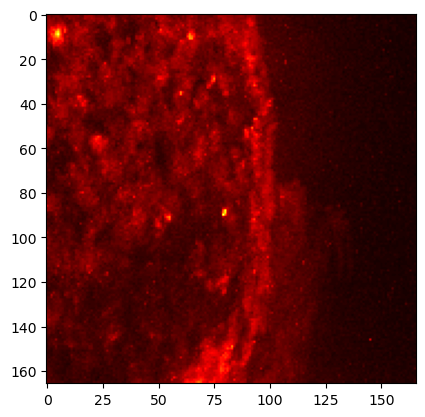

In [ ]:
# Function to update the plot
def update(frame):
    im.set_array(data_array[frame])
    return [im]

# Set up the plot
fig, ax = plt.subplots()
norm = Normalize(vmin=data_array.min(), vmax=data_array.max())  # Adjust as needed
im = ax.imshow(data_array[0], cmap='hot', norm=norm)  # Initialize with the first frame

# Create the animation
ani = FuncAnimation(fig, update, frames=range(30), blit=True)

# Display as HTML5 video in the notebook
HTML(ani.to_jshtml())

# 3. Evaluate the Image Sequence with the Model

In class RCNN we define the architecture of our Neural Network, to then import the weights from the .pth files

In [7]:
model=torch.load("./TransVOD/TransVOD_Lite-main/final_model_checkpoint0013.pth")
model.eval()

ModuleNotFoundError: No module named 'models'

In [ ]:
input_tensor = torch.tensor(data_array).unsqueeze(0)
input_tensor.shape

torch.Size([1, 30, 166, 166])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = './model evaluation//Trained_RCNN.pth'

model = torch.load(model_path, map_location=device)

model.eval()

model = model.to(device)

In [ ]:
with torch.no_grad():
    output = sigmoid(model(input_tensor)).item()

if output > threshold: 
    pred = 'jet'
else:
    pred = 'no jet'

<div style="width: 1350px; height: 30px; background-color: green;"></div>


In [ ]:
print('The probability of being a jet is {:.2f}%'.format(output*100))
print(f'For a threshold of {threshold}, the prediction is <<{pred}>>')

The probability of being a jet is 4.24%
For a threshold of 0.1, the prediction is <<no jet>>


<div style="width: 1350px; height: 30px; background-color: green;"></div>
